# Decision Trees Exercises

## Introduction

We will be using the wine quality data set for these exercises. This data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is `Wine_Quality_Data.csv`.

In [3]:
from __future__ import print_function
import os
data_path = ['data']

## Question 1

* Import the data and examine the features.
* We will be using all of them to predict `color` (white or red), but the colors feature will need to be integer encoded.

In [4]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Wine_Quality_Data.csv'])
data = pd.read_csv(filepath, sep=',')
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [5]:
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

In [6]:
data['color'] = data.color.replace({'white':0, 'red':1})
data['color'].dtype

C:\Users\34609\AppData\Local\Temp\ipykernel_9864\212731387.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['color'] = data.color.replace({'white':0, 'red':1})


dtype('int64')

## Question 2

* Use `StratifiedShuffleSplit` to split data into train and test sets that are stratified by wine quality. If possible, preserve the indices of the split for question 5 below.
* Check the percent composition of each quality level for both the train and test data sets.

In [7]:
feature_cols = [x for x in data.columns if x not in 'color']

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

#generator (split in 2 partes with 1000 points in test data)
strat = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=42)

train_idx, test_idx = next(strat.split(data[feature_cols], data['color']))

X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'color']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'color']


In [9]:
y_train.value_counts(normalize=True).sort_index()

color
0    0.753866
1    0.246134
Name: proportion, dtype: float64

In [10]:
y_test.value_counts(normalize=True).sort_index()

color
0    0.754
1    0.246
Name: proportion, dtype: float64

## Question 3

* Fit a decision tree classifier with no set limits on maximum depth, features, or leaves.
* Determine how many nodes are present and what the depth of this (very large) tree is.
* Using this tree, measure the prediction error in the train and test data sets. What do you think is going on here based on the differences in prediction error?

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

In [12]:
dt.tree_.node_count, dt.tree_.max_depth
# This is te maximum number of nodes and depth of the tree as we did not defined limits

(171, 22)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy': accuracy_score(y_true, y_pred),
                      'precision_score': precision_score(y_true, y_pred),
                      'recall_score': recall_score(y_true, y_pred),
                      'f1_score': f1_score(y_true, y_pred)},
                      name=label)


In [14]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                                   measure_error(y_test, y_test_pred, 'test')],
                                   axis=1)
train_test_full_error

,train,test
accuracy,0.999818,0.984000
precision_score,0.999261,0.963710
recall_score,1.000000,0.971545
f1_score,0.999631,0.967611


as we see, this is a overfitted scenario

## Question 4

* Using grid search with cross validation, find a decision tree that performs well on the test data set. Use a different variable name for this decision tree model than in question 3 so that both can be used in question 6.
* Determine the number of nodes and the depth of this tree.
* Measure the errors on the training and test sets as before and compare them to those from the tree in question 3.

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features':range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [16]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(99, 7)

In [17]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                   measure_error(y_test, y_test_pred_gr, 'test')],
                                   axis=1)
train_test_gr_error

,train,test
accuracy,0.995816,0.989000
precision_score,0.998501,0.983539
recall_score,0.984479,0.971545
f1_score,0.991440,0.977505


## Question 5

* Re-split the data into `X` and `y` parts, this time with `residual_sugar` being the predicted (`y`) data. *Note:* if the indices were preserved from the `StratifiedShuffleSplit` output in question 2, they can be used again to split the data.
* Using grid search with cross validation, find a decision tree **regression** model that performs well on the test data set.
* Measure the errors on the training and test sets using mean squared error.
* Make a plot of actual *vs* predicted residual sugar.

In [18]:
feature_cols = [x for x in data.columns if x != 'residual_sugar']

X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'residual_sugar']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'residual_sugar']


In [19]:
from sklearn.tree import DecisionTreeRegressor

dr= DecisionTreeRegressor().fit(X_train, y_train)

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features':range(1, len(dt.feature_importances_)+1)}

GR_sugar= GridSearchCV(DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  n_jobs=-1)

GR_sugar=GR_sugar.fit(X_train, y_train)

c:\Users\34609\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [20]:
GR_sugar.best_estimator_.tree_.node_count, GR_sugar.best_estimator_.tree_.max_depth

(6047, 17)

In [21]:
from sklearn.metrics import mean_squared_error

y_train_pred_gr_sugar = GR_sugar.predict(X_train)
y_test_pred_gr_sugar = GR_sugar.predict(X_test)

train_test_gr_sugar_error = pd.Series({'train':mean_squared_error(y_train, y_train_pred_gr_sugar),
                                   'test':mean_squared_error(y_test, y_test_pred_gr_sugar)},
                                   name='MSE').to_frame().T
train_test_gr_sugar_error

,train,test
MSE,0.043565,3.084644


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('dark')

%matplotlib inline

[Text(0.5, 0, 'Test'), Text(0, 0.5, 'Predict'), (0.0, 35.0), (0.0, 35.0)]

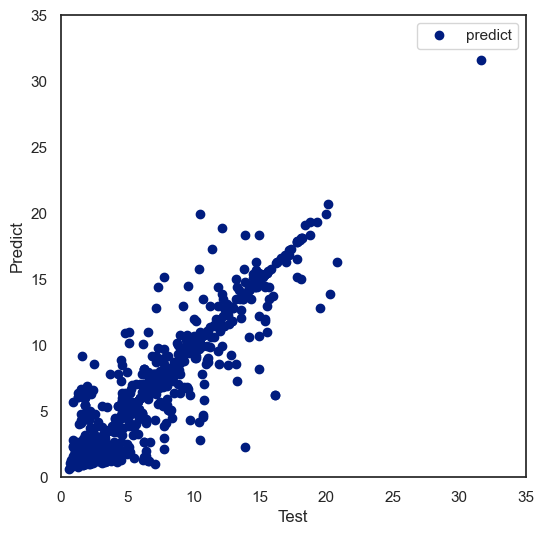

In [23]:
fig = plt.figure(figsize=(6,6))
ax=plt.axes()

ph_test_predict = pd.DataFrame({'test': y_test.values,
                                'predict': y_test_pred_gr_sugar}).set_index('test').sort_index()

ph_test_predict.plot(marker='o', ls='', ax=ax)
ax.set(xlabel='Test',
       ylabel='Predict',
       xlim=(0,35), ylim=(0,35))


## Question 6 *(Optional)*

This question is optional as it requires an additional command line program (GraphViz) and Python library (PyDotPlus). GraphViz can be installed with a package manager on Linux and Mac. For PyDotPlus, either `pip` or `conda` (`conda install -c conda-forge pydotplus`) can be used to install the library.

Once these programs are installed:

* Create a visualization of the decision tree from question 3, where wine color was predicted and the number of features and/or splits are not limited.
* Create a visualization of the decision tree from question 4, where wine color was predicted but a grid search was used to find the optimal depth and number of features.

The decision tree from question 5 will likely have too many nodes to visualize.

In [29]:
from io import StringIO
from IPython.display import Image, display

from sklearn.tree import export_graphviz

try:
    import pydotplus
    pydotplus_installed = True

except:
    print('Pydotplus must be installed to execute the remainder of the cells associated to the question')
    pydotplus_installed=False

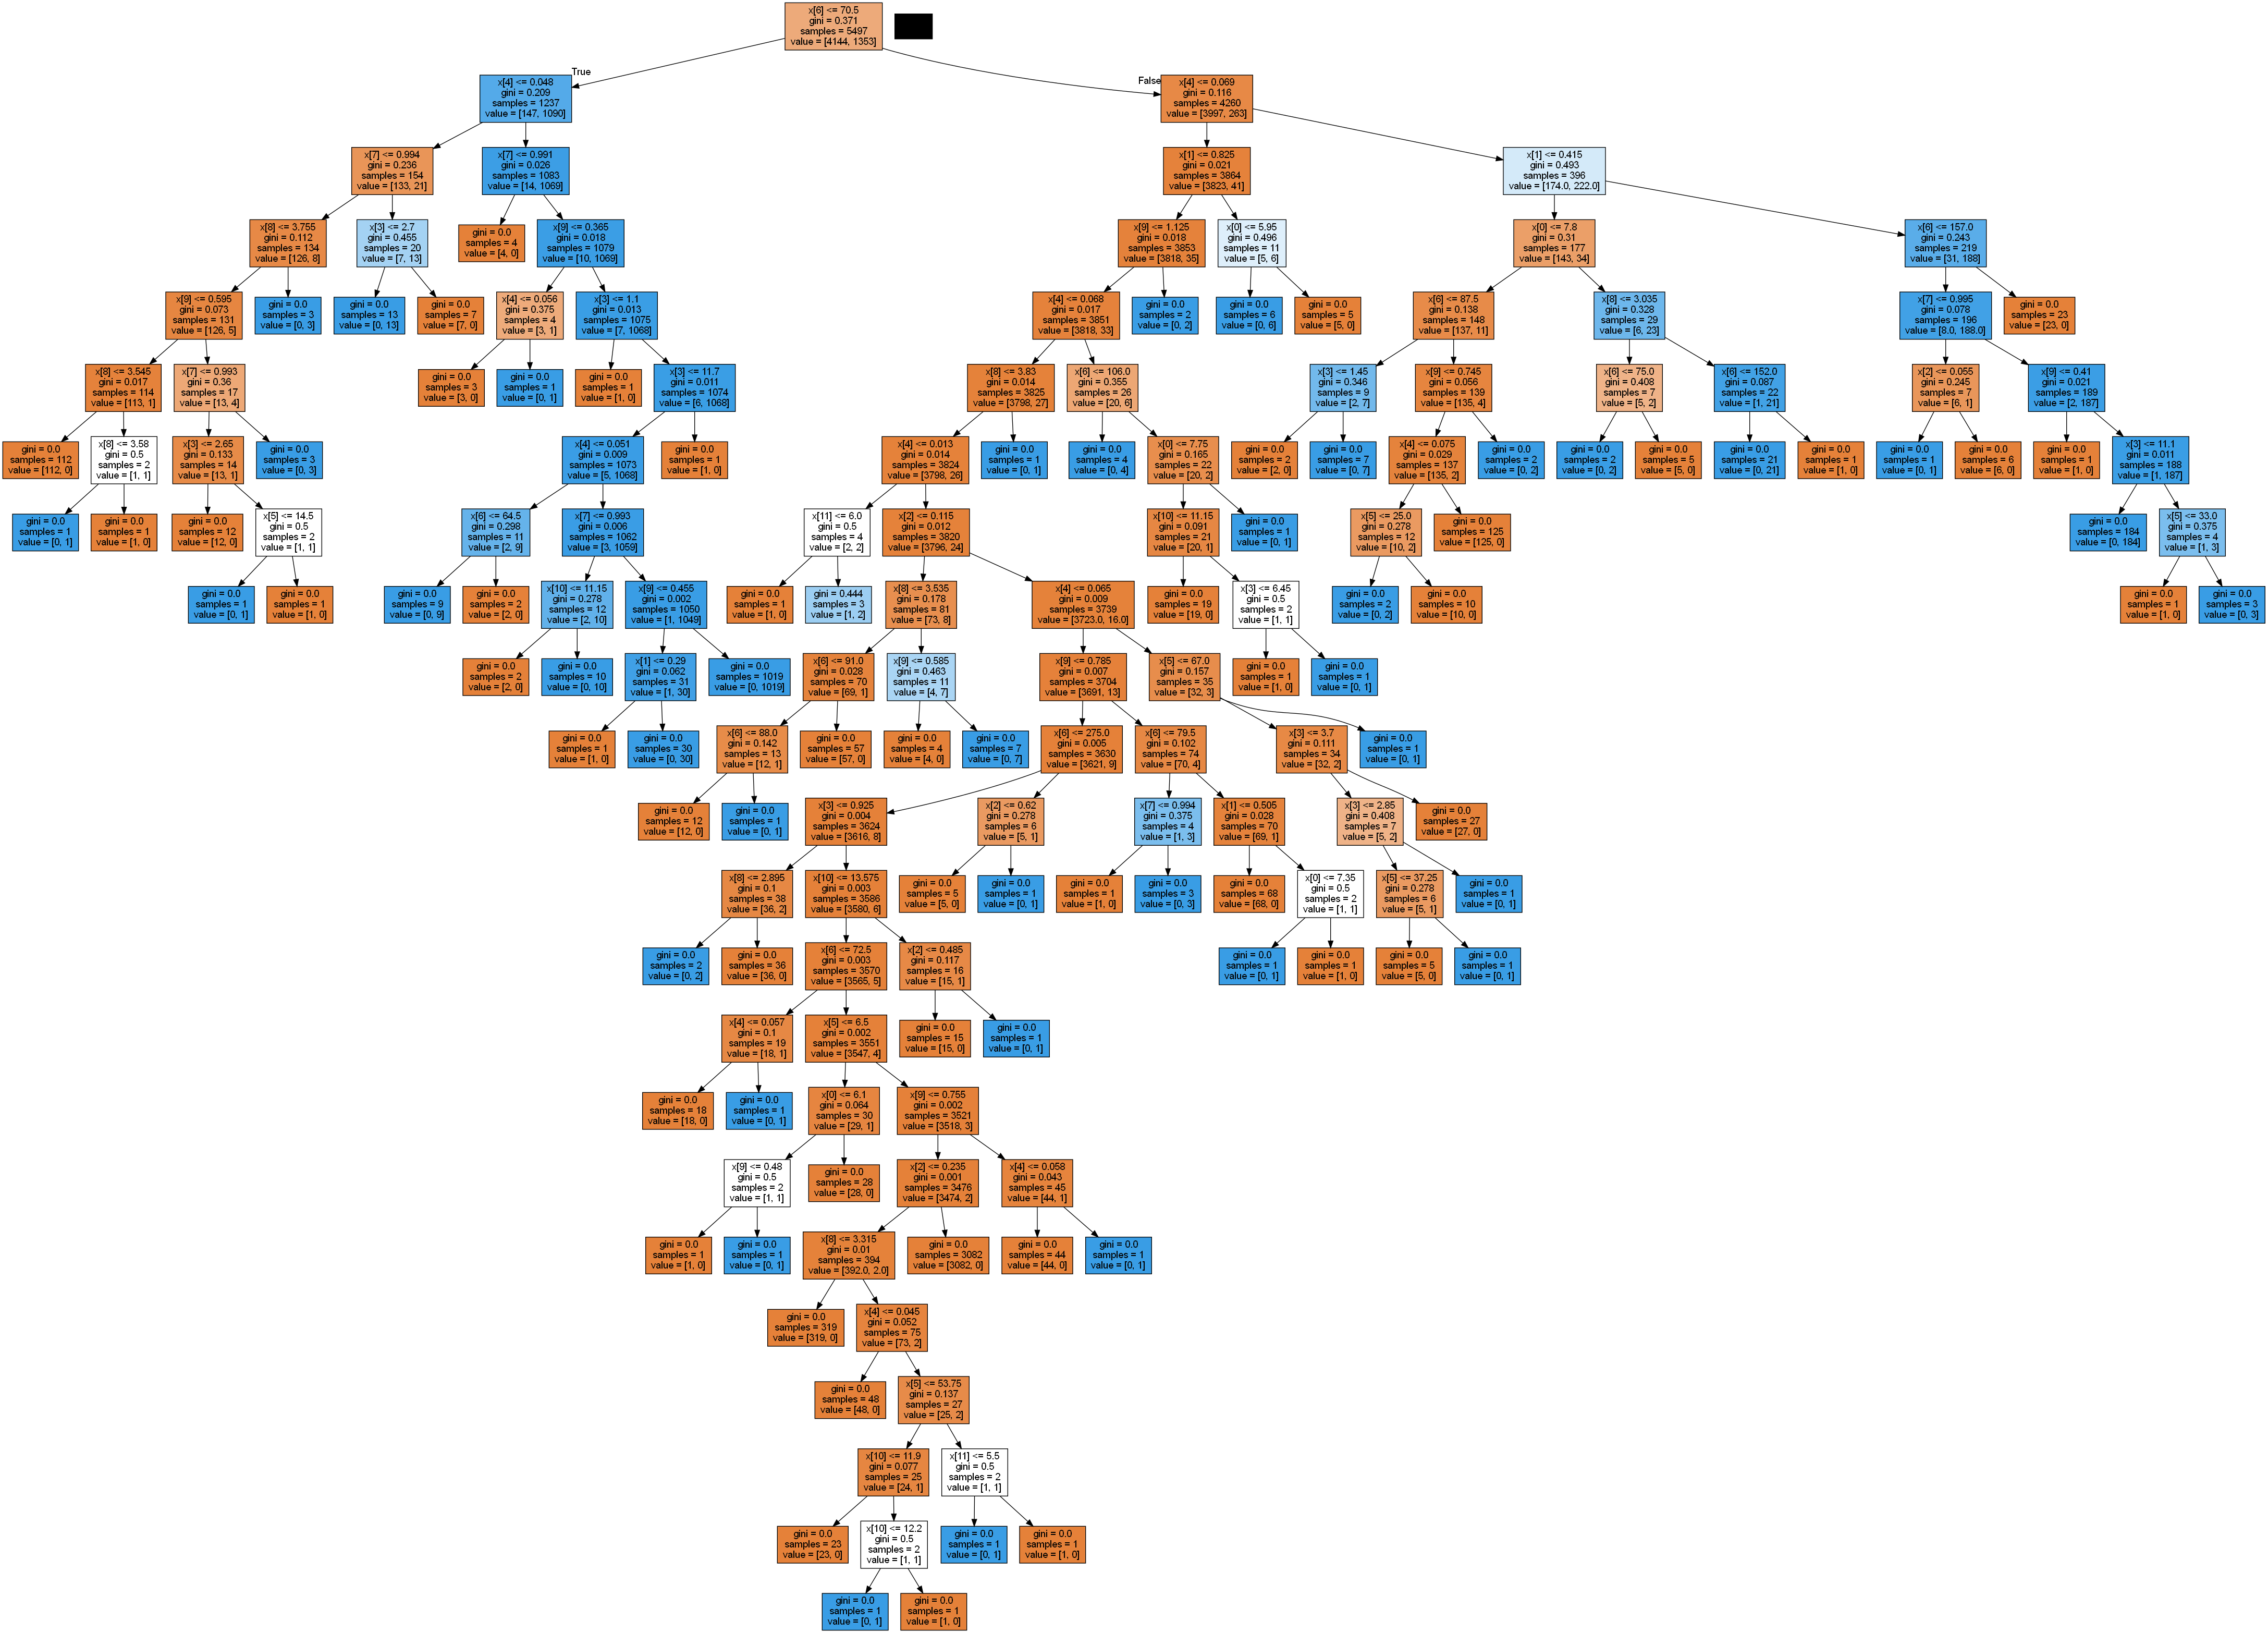

In [30]:

if pydotplus_installed:
    # Create an output destination for the file
    dot_data = StringIO()

    # Assuming `dt` is your decision tree model
    export_graphviz(dt, out_file=dot_data, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # View the tree image
    filename = 'wine_tree.png'
    graph.write_png(filename)
    img = Image(filename=filename)
    display(img)

else:
    print('This cell not executed because PyDotPlus could not be loaded.')

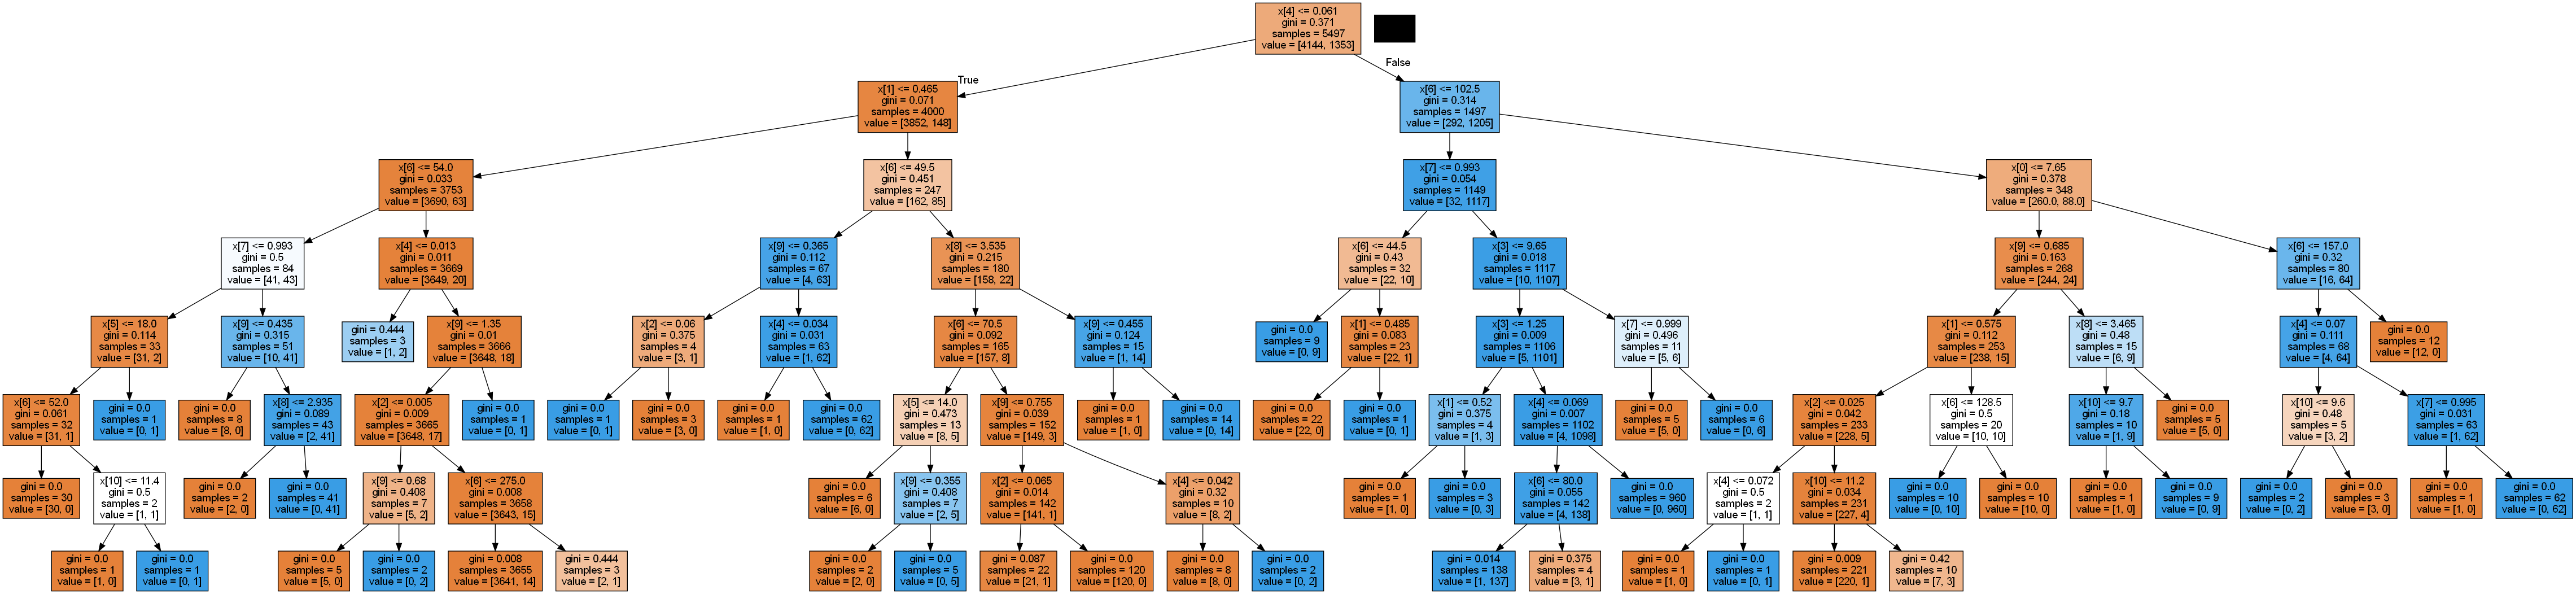

In [32]:
if pydotplus_installed:
    # Create an output destination for the file
    dot_data = StringIO()

    # Assuming `GR.best_estimator_` is your pruned decision tree model
    export_graphviz(GR.best_estimator_, out_file=dot_data, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # View the pruned tree image
    filename = 'wine_tree_prune.png'
    graph.write_png(filename)
    img = Image(filename=filename)
    display(img)
else:
    print('This cell not executed because PyDotPlus could not be loaded.')